# **Homework 1: COVID-19 Cases Prediction (Regression)**

Author: Heng-Jui Chang

Slides: https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.pdf  
Video: TBA

Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Get familiar with PyTorch.

If any questions, please contact the TAs via TA hours, NTU COOL, or email.


# **Download Data**


If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

In [1]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

# !gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
# !gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

# **Import Some Packages**

In [2]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset

# For data preprocess
import numpy as np
import csv
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# prevent from using gpu working on other's tasks in lab

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 52728  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    print("cuda_available")
    torch.cuda.manual_seed_all(myseed)

cuda_available


# **Some Utilities**

You do not need to modify this part.

In [3]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

# **Preprocess**

We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

## **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

Finishing `TODO` below might make you pass medium baseline.

In [4]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=False,
                 mean=0,
                 std=0,
                 ae=None,
                 device='cuda'):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        if not target_only:
            feats = list(range(93))
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            # feats = list(range(40+12)) + [57, 75] + list(range(58, 58+12)) + list(range(76, 76+12))
            feats = list(range(40)) + [57, 75] + list(range(76, 76+4)) + list(range(40, 48))
        

            
        norm_id = 40
        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            if ae:
                data = torch.FloatTensor(data).to(device)
                self.data = ae.encode(data).detach().cpu()
            else:
                data = data[:, feats]
                self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]
            
            # Using random_split here instead of manual spliting

            # Splitting training data into train & dev sets
            # if mode == 'train':
            #     indices = [i for i in range(len(data)) if i % 10 != 0]
            # elif mode == 'dev':
            #     indices = [i for i in range(len(data)) if i % 10 == 0]
            
            # Convert data into PyTorch tensors

            # self.data = torch.FloatTensor(data[indices])
            # self.target = torch.FloatTensor(target[indices])
            if ae:
                data = torch.FloatTensor(data).to(device)
                self.data = ae.encode(data).detach().cpu()
            else:
                self.data = torch.FloatTensor(data)
            self.target = torch.FloatTensor(target)
        self.mean = self.data[:, norm_id:].mean(dim=0, keepdim=True)
        self.std = self.data[:, norm_id:].std(dim=0, keepdim=True)
        mean = self.mean
        std = self.std

        # Normalize features (you may remove this part to see what will happen)
        # normalize the data except state and tested_pos
        # norm_id = 40+2 # move to earlier
        # self.data[:, norm_id:] = \
        #     (self.data[:, norm_id:] - self.data[:, norm_id:].mean(dim=0, keepdim=True)) \
        #     / self.data[:, norm_id:].std(dim=0, keepdim=True)

        # self.data[:, norm_id:] = (self.data[:, norm_id:] - mean) / std

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [5]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False, split_indices=None, mean=0, std=0, ae=None, device='cuda'):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only, mean=mean, std=std, ae=ae, device=device)  # Construct dataset
    if split_indices is None:
        dataloader = DataLoader(
            dataset, batch_size,
            shuffle=(mode=='train'), drop_last=False,
            num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
        return dataloader
    else:
        # n = len(dataset)
        # if n_dev <= 0:
        #     n_dev = int(0.1 * len(dataset))
        # d_train, d_dev = random_split(dataset, [n - n_dev, n_dev])
        mean, std = dataset.mean, dataset.std
        d_train = Subset(dataset, split_indices[0])
        d_dev = Subset(dataset, split_indices[1])
        print(f"Split training dataset into {len(d_train)}, {len(d_dev)}")
        dataloader_tr = DataLoader(
            dataset, batch_size, # TODO: Train with full train set?
            shuffle=True, drop_last=False,
            num_workers=n_jobs, pin_memory=True)
        
        dataloader_dev = DataLoader(
            d_train, batch_size,
            shuffle=True, drop_last=False,
            num_workers=n_jobs, pin_memory=True)
        return dataloader_tr, dataloader_dev, mean, std

# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [59]:
class AE(nn.Module):
    def __init__(self, input_dim, feat_dim):
        super(AE, self).__init__()
        
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 40),
            # nn.BatchNorm1d(40),
            nn.ReLU(),
            nn.Linear(40, feat_dim),
        )

        self.dec = nn.Sequential(
            # nn.BatchNorm1d(feat_dim),
            nn.ReLU(),
            nn.Linear(feat_dim, 40),
            # nn.BatchNorm1d(40),
            nn.ReLU(),
            nn.Linear(40, input_dim),
        )
        self.criterion = nn.MSELoss(reduction='mean')
    
    def forward(self, x):
        return self.dec(self.enc(x))
    
    def cal_loss(self, pref, tar):
        return self.criterion(pref, tar)

    def encode(self, x):
        return self.enc(x)

In [58]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim, reg_lambda = 0.1):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        # Mean squared error loss
        self.reg_lambda = reg_lambda
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L2 regularization here
        # reg = 0
        # for p in self.parameters():
        #     reg += torch.sum(p**2)
        # return self.criterion(pred, target) + self.reg_lambda * reg
        return self.criterion(pred, target)

# **Train/Dev/Test**

## **Training**

In [8]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    reg = config.get('reg')
    if reg:
    # if False:
        print("Not apply l2-reg on bias")
        weight_p, bias_p = [], []
        for name, p in model.named_parameters():
            if 'bias' in name:
                bias_p += [p]
            else:
                weight_p += [p]
        optimizer = getattr(torch.optim, config['optimizer'])([
            {'params' : weight_p, 'weight_decay' : config['reg']},
            {'params' : bias_p, 'weight_decay' : 0}
            ], **config['optim_hparas'])
    else:
        print("Apply l2-reg on bias")
        optimizer = getattr(torch.optim, config['optimizer'])(
            model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    save_count = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        tr_loss = []
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            tr_loss.append(mse_loss.detach().cpu().item())
        loss_record['train'] += tr_loss

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, tr_loss = {:.4f}, dv_loss = {:.4f})'
                .format(epoch + 1, np.mean(tr_loss), min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            # print('Saving model (epoch = {:4d}, tr_loss = {:.4f}, dv_loss = {:.4f})'
            #     .format(epoch + 1, mse_loss, dev_mse))
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

In [9]:
def ae_train(tr_sets, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    reg = config.get('reg')
    if reg:
    # if False:
        print("Not apply l2-reg on bias")
        weight_p, bias_p = [], []
        for name, p in model.named_parameters():
            if 'bias' in name:
                bias_p += [p]
            else:
                weight_p += [p]
        optimizer = getattr(torch.optim, config['optimizer'])([
            {'params' : weight_p, 'weight_decay' : config['reg']},
            {'params' : bias_p, 'weight_decay' : 0}
            ], **config['optim_hparas'])
    else:
        print("Apply l2-reg on bias")
        optimizer = getattr(torch.optim, config['optimizer'])(
            model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = []      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    save_count = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        tr_loss = []
        for s in tr_sets:
            for x in s:                     # iterate through the dataloader
                x = x[0]
                optimizer.zero_grad()               # set gradient to zero
                x = x.to(device)   # move data to device (cpu/cuda)
                pred = model(x)                     # forward pass (compute output)
                mse_loss = model.cal_loss(pred, x)  # compute loss
                mse_loss.backward()                 # compute gradient (backpropagation)
                optimizer.step()                    # update model with optimizer
                tr_loss.append(mse_loss.detach().cpu().item())
        
        loss_record += tr_loss

        print('Saving model (epoch = {:4d}, tr_loss = {:.4f})'
                .format(epoch + 1, np.mean(tr_loss)))

        epoch += 1
        

    print('Finished training after {} epochs'.format(epoch))
    return loss_record

## **Validation**

In [10]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

In [11]:
def ae_dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x = x.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, x)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss
    return total_loss

## **Testing**

In [12]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [45]:

device = get_device()                 # get the current available device ('cpu' or 'cuda')
# print(device)
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = False                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_dev': 200,           # num of dev set
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 200,               # mini-batch size for dataloader
    'reg': 1e-4,
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 1e-4,                  # learning rate of SGD
        # 'momentum': 0.6,             # momentum for SGD
        # 'weight_decay': 1e-4,      # l2-reg in optim (might regularize the bias)
    },
    'early_stop': 300,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

ae_config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 100,               # mini-batch size for dataloader
    'reg': 1e-5,
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 2e-4,                  # learning rate of SGD
        'momentum': 0.8,             # momentum for SGD
        # 'weight_decay': 1e-4,      # l2-reg in optim (might regularize the bias)
    },
    'early_stop': 300,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/ae_model.pth'  # your model will be saved here
}

# **Load data and model**

In [30]:
# random permutation
n = 2700
split_indices = torch.randperm(n)
dv_idx, tr_idx = split_indices[:config['n_dev']], split_indices[config['n_dev']:]

In [31]:
tr_set, dv_set, mean, std = prep_dataloader(tr_path, 'train', config['batch_size'],
    target_only=target_only, split_indices=[tr_idx, dv_idx])
# dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only, mean=mean, std=std)

Finished reading the train set of COVID19 Dataset (2700 samples found, each dim = 93)
Split training dataset into 2500, 200
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 93)


In [38]:
# AE
# ae = AE(dv_set.dataset[0][0].shape[0], 60).to(device)
ae_train([tr_set, dv_set, tt_set], ae, ae_config, device)

Saving model (epoch = 2567, tr_loss = 0.1963)
Saving model (epoch = 2568, tr_loss = 0.1959)
Saving model (epoch = 2569, tr_loss = 0.1954)
Saving model (epoch = 2570, tr_loss = 0.1954)
Saving model (epoch = 2571, tr_loss = 0.1958)
Saving model (epoch = 2572, tr_loss = 0.1950)
Saving model (epoch = 2573, tr_loss = 0.1952)
Saving model (epoch = 2574, tr_loss = 0.1948)
Saving model (epoch = 2575, tr_loss = 0.1956)
Saving model (epoch = 2576, tr_loss = 0.1949)
Saving model (epoch = 2577, tr_loss = 0.1948)
Saving model (epoch = 2578, tr_loss = 0.1947)
Saving model (epoch = 2579, tr_loss = 0.1946)
Saving model (epoch = 2580, tr_loss = 0.1946)
Saving model (epoch = 2581, tr_loss = 0.1946)
Saving model (epoch = 2582, tr_loss = 0.1947)
Saving model (epoch = 2583, tr_loss = 0.1942)
Saving model (epoch = 2584, tr_loss = 0.1937)
Saving model (epoch = 2585, tr_loss = 0.1942)
Saving model (epoch = 2586, tr_loss = 0.1940)
Saving model (epoch = 2587, tr_loss = 0.1936)
Saving model (epoch = 2588, tr_los

68391799926758,
 26.688478469848633,
 20.418262481689453,
 17.930713653564453,
 15.04876708984375,
 15.160423278808594,
 16.555097579956055,
 11.873723983764648,
 11.977972030639648,
 9.001541137695312,
 22.856189727783203,
 8.118382453918457,
 15.68116569519043,
 14.921669960021973,
 14.698424339294434,
 14.07082748413086,
 13.91403579711914,
 15.505298614501953,
 13.905010223388672,
 14.790595054626465,
 15.416213035583496,
 14.224870681762695,
 13.631961822509766,
 14.42336368560791,
 14.333317756652832,
 13.757784843444824,
 13.358466148376465,
 13.930075645446777,
 15.597228050231934,
 13.66593074798584,
 13.821874618530273,
 13.491864204406738,
 14.277496337890625,
 14.560457229614258,
 13.468399047851562,
 14.1551513671875,
 13.81551742553711,
 13.944670677185059,
 14.117218017578125,
 8.94405460357666,
 8.427806854248047,
 6.47447395324707,
 21.757768630981445,
 6.973102569580078,
 14.377745628356934,
 14.55660629272461,
 14.16594123840332,
 14.46770191192627,
 14.0288581848144

In [39]:
ae_tr_set, ae_dv_set, mean, std = prep_dataloader(tr_path, 'train', config['batch_size'],
    target_only=target_only, split_indices=[tr_idx, dv_idx], ae=ae, device=device)
# dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
ae_tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only, mean=mean, std=std, ae=ae, device=device)

Finished reading the train set of COVID19 Dataset (2700 samples found, each dim = 60)
Split training dataset into 2500, 200
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 60)


In [49]:
# model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device
# model = NeuralNet(dv_set.dataset[0][0].shape[0], reg_lambda=config['reg']).to(device)  # Construct model and move to device
# print(ae_tr_set.dataset[0][0].shape[0])
model = NeuralNet(ae_tr_set.dataset[0][0].shape[0]).to(device)  # Construct model and move to device
# model = NeuralNet(dv_set.dataset[0][0].shape[0]).to(device)  # Construct model and move to device
# ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
# model.load_state_dict(ckpt)

# **Start Training!**

In [50]:
model_loss, model_loss_record = train(ae_tr_set, ae_dv_set, model, config, device)

model (epoch =   70, tr_loss = 243.6784, dv_loss = 241.7408)
Saving model (epoch =   72, tr_loss = 242.3637, dv_loss = 241.4220)
Saving model (epoch =   73, tr_loss = 242.1580, dv_loss = 241.3714)
Saving model (epoch =   74, tr_loss = 240.1395, dv_loss = 240.0038)
Saving model (epoch =   75, tr_loss = 241.1592, dv_loss = 239.6937)
Saving model (epoch =   76, tr_loss = 239.8829, dv_loss = 238.7958)
Saving model (epoch =   77, tr_loss = 239.7368, dv_loss = 238.0104)
Saving model (epoch =   78, tr_loss = 237.3129, dv_loss = 236.4144)
Saving model (epoch =   79, tr_loss = 237.1253, dv_loss = 236.2230)
Saving model (epoch =   80, tr_loss = 234.9958, dv_loss = 234.8131)
Saving model (epoch =   83, tr_loss = 232.9112, dv_loss = 231.0234)
Saving model (epoch =   84, tr_loss = 231.2015, dv_loss = 230.3745)
Saving model (epoch =   85, tr_loss = 228.9741, dv_loss = 227.9570)
Saving model (epoch =   88, tr_loss = 226.2327, dv_loss = 225.6740)
Saving model (epoch =   90, tr_loss = 225.3195, dv_loss

In [16]:
for n, p in model.named_parameters():
    if 'bias' in n:
        w = p.norm(2).item()
        print(n, w)

net.0.bias 1.8137184381484985
net.2.bias 1.4298698902130127
net.4.bias 1.8457872867584229


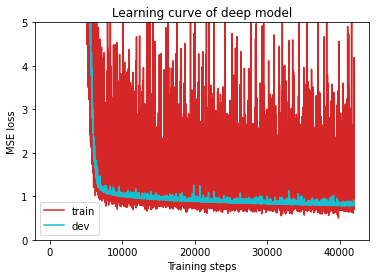

In [51]:
plot_learning_curve(model_loss_record, title='deep model')

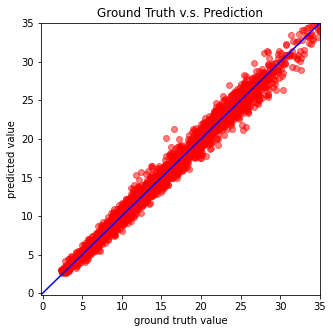

In [55]:
del model
# model = NeuralNet(dv_set.dataset[0][0].shape[0]).to(device)
model = NeuralNet(ae_tr_set.dataset[0][0].shape[0]).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(ae_tr_set, model, device)  # Show prediction on the validation set
# plot_pred(dv_set, model, device)  # Show prediction on the validation set

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [57]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

# preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
preds = test(ae_tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv


# **Hints**

## **Simple Baseline**
* Run sample code

## **Medium Baseline**
* Feature selection: 40 states + 2 `tested_positive` (`TODO` in dataset)

## **Strong Baseline**
* Feature selection (what other features are useful?)
* DNN architecture (layers? dimension? activation function?)
* Training (mini-batch? optimizer? learning rate?)
* L2 regularization
* There are some mistakes in the sample code, can you find them?

# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author. 

E.g.  
Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)
